# Projeto Final Análises de Texto de Fontes Desestruturadas e Web
## Autores:
### Gabriel Lopes Monteiro
### Guilherme Peres Leite

## Professor:
### Maciel Calebe Vidal

___

# Análise da influência de torcedores no resultado final de jogos da temporada regular da NBA

## Introdução

Durante o ano de 2020 o mundo foi atingido pela pandemia da Covid-19, que impactou todos o setores da sociedade incluindo o setor esportivo. No dia 11 de março de 2020, o então comissário da NBA, Adam Silver, anunciou a suspensão da temporada regular 2019-20 da liga americana de basquete após alguns casos positivos da doença. Está temporada acabou terminando de forma atípica em uma espécie de "bolha" no complexo esportivo da Walt Disney World, na Flórida. Dessa forma, os jogos realizados tiveram campo neutro. As finais acabaram em 11 de outubro de 2020, diferente do padrão em que as finais terminavam entre os meses de maio e junho.

Após o encerramento da temporada 2019-20, começou a ser discutido sobre o início da temporada 2020-21. Devido ao alto custo da "bolha" em Orlando, a organização da NBA decidiu por voltar a realizar os jogos nos ginásios oficiais dos times, porém sem a presença da torcida. Também se alterou o número de jogos totais da temporada regular, de 82 jogos para cada time esse número mudou para 72, uma vez que as férias dos jogadores seriam mais curtas que o normal. A temporada regular 2020-21 iniciou em 22 de dezembro de 2020 e acabou dia 16 de maio de 2021. Os playoffs estão em andamento e devido ao alto índice de vacinação nos Estados Unidos, a torcida já está de volta aos estádios.


### Problema

Diversas análises já foram feitas visando entender a influência do campo neutro nos playoffs da temporada 2019-20 na "bolha" de Orlando. Este trabalho busca analisar a influência dos torcedores em jogos em casa e jogos fora de casa na temporada regular, uma vez que os jogos de playoffs atuais já contam com a presença de torcida, mesmo que parcial. Como base para essa análise, foram utilizados os resultados de jogos referentes a temporada 2018-19, pré pandemia, e os resultados de jogos referentes a temporada regular 2020-21, em que não se havia presença de torcedores nos ginásios.

___


## Extração de dados

Como forma de investigar os resultados de jogos em casa e fora comparando as temporadas regulares 2018-19 e 2020-21, a extração de dados precisa garantir: 

- Quais times se enfrentaram
- Qual era o time da casa e qual time era visitante
- Resultado do jogo 
- Pontuações dos times

Dessa forma, a estratégia escolhida para extrair todas as informações necessárias foi Web Scrapping. Foram desenvolvidas algumas funções responsáveis por extrair esses dados na grade de jogos do site oficial da [ESPN americana](https://www.espn.com/nba/schedule/). 

Além de extrair esses dados, foi necessário formata-los para um objeto DataFrame da biblioteca pandas do Python para posteriormente realizar as análises. Abaixo se encontra os códigos referentes a essa extração e formatação dos dados, com comentários.

In [2]:
import mechanicalsoup
from bs4 import BeautifulSoup
from requests_html import HTMLSession
import dateutil.parser
import datetime
import sys
import json
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
session = HTMLSession()
browser = mechanicalsoup.StatefulBrowser()
browser.addheaders = [('User-agent', 'Firefox')]

In [4]:
def get_games(date):
    '''
        Get NBA games on a particular day
        The data is being screapped from the espn.com site
        date:   YYYYMMDD format
    '''

    games_dict = {}
    gameIndex = 0

    browser.open("https://www.espn.com/nba/schedule/_/date/"+date) # URL containig the games for the given date 

    # Opening the link
    schedule_link = browser.find_link()
    browser.follow_link(schedule_link)

    page = browser.get_current_page() # get the page source code
    games = page.find(class_="schedule has-team-logos align-left") # select only the tag that contains the games' info
    desc_all = games.find_all('small') # Game description

    # return games_dict
    for game in games.find_all('tr'):
        teams = []

        contents = game.find_all('td')
        for content in contents:
            for td in content.find_all('abbr'):
                teams.append(td.get('title'))

        if contents:
            element_list = str(contents[2]).split('>')
            gameId = str(element_list[1][52:-36]) # Isolates the game ID
            date = str(element_list[0][41:-1]) # Isolates the result
            time = str(dateutil.parser.parse(date))[:-9] # Converts date time from ISO 8601:

            teams.reverse() # Inverts the order to use the Home vs. Away format
            games_dict[gameId] = teams , time # Adds the game to a dictionary using the ID as key

            gameIndex+=1

    return games_dict

In [5]:
def get_results(date):
    '''
        Get the results NBA games on a particular day
        The data is being screapped from the espn.com site
        date:   YYYYMMDD format
    '''

    games_dict = {}
    gameIndex = 0

    browser.open("https://www.espn.com/nba/schedule/_/date/"+date) # URL containig the games for the given date 

    # Opening the link
    schedule_link = browser.find_link()
    browser.follow_link(schedule_link)

    page = browser.get_current_page() # get the page source code
    games = page.find(class_="schedule has-team-logos align-left") # select only the tag that contains the games' info

    for game in games.find_all('tr'):
        teams = []

        contents = game.find_all('td')
        for content in contents:
            for td in content.find_all('abbr'):
                teams.append(td.get('title'))

        if contents:
            element_list = str(contents[2]).split('>')
            gameId = str(element_list[1][28:-37]) # Isolates the game ID
            result = str(element_list[2][:-3]) # Isolates the result

            teams.reverse() # Inverts the order to use the Home vs. Away format
            games_dict[gameId] = teams , result # Adds the game to a dictionary using the ID as key

            gameIndex+=1

    return games_dict

In [6]:
def DictToDf(dic):
    '''
    Convert dictionary generated from scrapping to a Pandas Dataframe
    dic: {'gameID': (['Home', 'Away'], 'WIN_ABREV WIN_POINTS, LOS_ABREV LOS_POINTS'
    '''
    
    df = pd.DataFrame.from_dict(dic,orient='index')
    
    # Getting Home and Away teams from list and creating a column for each of them
    df.loc[:, 'Home'] = df[0].map(lambda x: x[0]) 
    df.loc[:, 'Away'] = df[0].map(lambda x: x[1])
    df = df.drop(0,axis=1)
    
    df = df.rename(columns={1: "Result"})
    df.index.name = "Game_ID"

    return df

In [7]:
def getAbrev():
    '''
    Scrapes Wikipedia page to get a dictionary with NBA teams names and abreviations
    '''
    
    url2 = "https://en.wikipedia.org/wiki/Wikipedia:WikiProject_National_Basketball_Association/National_Basketball_Association_team_abbreviations"

    response = requests.get(
        url=url2,
    )
    soup = BeautifulSoup(response.content, 'html.parser')

    results = {}
    for row in soup.findAll('tr'):
        aux = row.findAll('td')
        try:
            results[aux[0].string[:-1]] = aux[1].find('a').text
        except:
            pass
    
    results["NY"] =  results["NYK"]
    results["UTAH"] =  results["UTA"]
    results["NO"] =  results["NOP"]
    results["SA"] =  results["SAS"]
    results["WSH"] =  results["WAS"]
    results["LAC"] = "LA Clippers"
    results["GS"] =  results["GSW"]
    
    
    return results

In [8]:
def formatResult(df):
    '''
    Formats the Dataframe 
    '''
    
    Won = []
    Won_Points = []
    Lost = []
    Lost_Points = []
    abrev = getAbrev()

    for r in range(len(df.Result)):
        row=df.Result[r]
        teams = row.split(',')
        name_res = [team.split(' ') for team in teams]

        if name_res[0][0] in abrev and  name_res[1][1] in abrev:
            Won.append(abrev[name_res[0][0]])
            Won_Points.append(name_res[0][1])

            Lost.append(abrev[name_res[1][1]])
            Lost_Points.append(name_res[1][2])

        else: # Days without games or with exibition matches or postponed
           pass

    if name_res[0][0] != "Postponed":
        df["Won"] = Won
        df["Won_Points"] = Won_Points
        df["Lost"] = Lost
        df["Lost_Points"] = Lost_Points

        df['Home_Won'] = np.where((df['Home'] == df['Won']), "Yes", "No")
    
    return df

In [9]:
def getByDay(date):
    '''
    Creates a Dataframe with de scraped and cleaned data for a specific day
    date:   DD/MM/YYYY format
    '''

    now = datetime.datetime.now()

    # Changing the date format to use in the URL
    date_split = date.split('/')
    date = [date_split[2],date_split[1],date_split[0]]
    date = ''.join(date)

    #Checking if the given date is in the past
    if now.year > int(date_split[2]) or now.month > int(date_split[1]) or now.day > int(date_split[0]):
        dic = get_results(date)
        df = DictToDf(dic)
        df["Date"] = [date]*len(df)

        df = formatResult(df)
        
        # df.to_csv('./games/games'+date+'.csv')
        
        return df

    else:
        dic = get_games(date)
        df = DictToDf(dic)
        df["Date"] = [end_date]*len(df)
        # df.to_csv('./dates/dates'+date+'.csv')
        
        return df

In [10]:
def main(start_date, end_date):
    '''
    Returns DataFrames relative to start and end days
    '''

    dfs = []
    
    for day in pd.period_range(start=start_date, end=end_date, freq='D'):
        try:
            dfs.append(getByDay(str(day.strftime("%d/%m/%Y"))))
        except:
            pass
#             print(day)
            
    return dfs

In [11]:
def concatCSV(start_date,end_date,path_to_save,name):
    '''
    Concats different DataFrames with games of the day into a single one
    and exports it to csv
    '''
    
    dfs = main(start_date,end_date)
    total_df = pd.concat(dfs)
    total_df.to_csv(path_to_save+name+'.csv')

### Extraindo dados de interesse

Descomentar células abaixo para puxar os dados
- *O processo é lento*

In [38]:
path = './games/' # Path to the folder where data is saved

In [39]:
# Pulls data from 2018-19 regular season
#concatCSV("16/10/2018","10/04/2019",path,"regular_2018-19")

In [40]:
# Pulls data from 2020-21 regular season
#concatCSV("22/12/2020","16/04/2021",path,"regular_2020-21")

### Leitura dos dados

Com os dados de interesse salvos, agora estes podem ser lidos e concatenados em um único DataFrame formatado para ser analisado.

In [54]:
regular_18_19 = pd.read_csv(path+'regular_2018-19.csv')
regular_18_19['Season'] = "2018-19"
regular_20_21 = pd.read_csv(path+'regular_2020-21.csv')
regular_20_21['Season'] = "2020-21"
df = pd.concat([regular_18_19,regular_20_21])
df['Home_Points'] = np.where((df['Home_Won'] == 'Yes'), df['Won_Points'], df['Lost_Points'])
df['Away_Points'] = np.where((df['Home_Won'] == 'Yes'), df['Lost_Points'], df['Won_Points'])
df

,Game_ID,Result,Home,Away,Date,Won,Won_Points,Lost,Lost_Points,Home_Won,Season,Home_Points,Away_Points
0,401070213,"BOS 105, PHI 87",Boston Celtics,Philadelphia 76ers,20181016,Boston Celtics,105.0,Philadelphia 76ers,87.0,Yes,2018-19,105.0,87.0
1,401070214,"GS 108, OKC 100",Golden State Warriors,Oklahoma City Thunder,20181016,Golden State Warriors,108.0,Oklahoma City Thunder,100.0,Yes,2018-19,108.0,100.0
2,401070693,"MIL 113, CHA 112",Charlotte Hornets,Milwaukee Bucks,20181017,Milwaukee Bucks,113.0,Charlotte Hornets,112.0,No,2018-19,112.0,113.0
3,401070694,"DET 103, BKN 100",Detroit Pistons,Brooklyn Nets,20181017,Detroit Pistons,103.0,Brooklyn Nets,100.0,Yes,2018-19,103.0,100.0
4,401070695,"IND 111, MEM 83",Indiana Pacers,Memphis Grizzlies,20181017,Indiana Pacers,111.0,Memphis Grizzlies,83.0,Yes,2018-19,111.0,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,401307646,"MEM 126, CHI 115",Chicago Bulls,Memphis Grizzlies,20210416,Memphis Grizzlies,126.0,Chicago Bulls,115.0,No,2020-21,115.0,126.0
672,401307647,"DEN 128, HOU 99",Houston Rockets,Denver Nuggets,20210416,Denver Nuggets,128.0,Houston Rockets,99.0,No,2020-21,99.0,128.0
673,401307648,"MIN 119, MIA 111",Minnesota Timberwolves,Miami Heat,20210416,Minnesota Timberwolves,119.0,Miami Heat,111.0,Yes,2020-21,119.0,111.0
674,401307649,"POR 107, SA 106",San Antonio Spurs,Portland Trail Blazers,20210416,Portland Trail Blazers,107.0,San Antonio Spurs,106.0,No,2020-21,106.0,107.0


___

## Análise dos dados



### Vitórias de times locais

A primeira análise procura saber se os times da casa costumam vencer a maioria dos jogos que são realizados em seus ginásios e se isso mudou de alguma forma com a falta de torcedores nos jogos na temporada regular 2020-21.

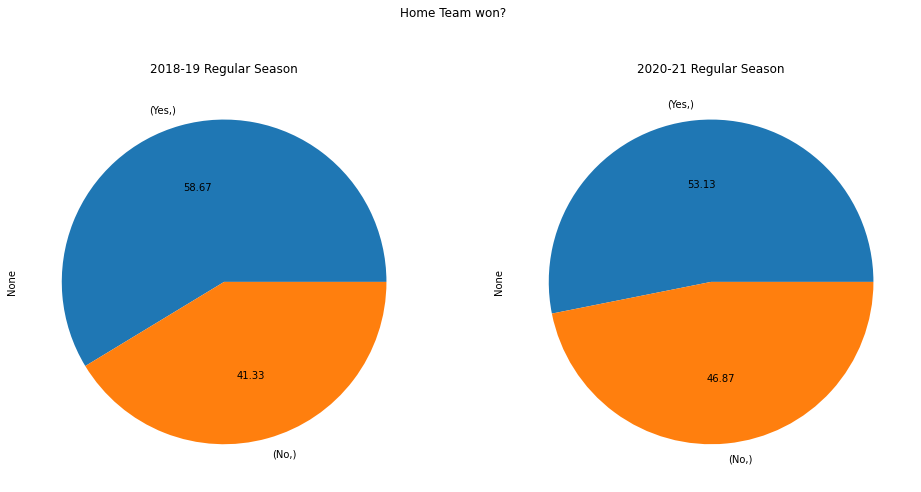

In [55]:
f = plt.figure(figsize=(16,8))
f.suptitle('Home Team won?')

ax0 = plt.subplot(121)
ax0.set_title('2018-19 Regular Season')
df.loc[df['Season']=='2018-19'][['Home_Won']].value_counts().plot.pie(subplots=True,autopct='%0.2f')

ax1 = plt.subplot(122)
ax1.set_title('2020-21 Regular Season')
df.loc[df['Season']=='2020-21'][['Home_Won']].value_counts().plot.pie(subplots=True,autopct='%0.2f')

plt.show()

Na temporada regular 2018-19, os times em casa tiveram uma vantagem clara, já que mais da metade ganharam os jogos disputados em seus ginásios. Na temporada regular 2020-21 essa vantagem se mantém, mas com um aproveitamento visivelmente inferior em relação a temporada regular 2018-19, uma queda de 5,54%.

### Pontuação de times locais e times visitantes

A segunda análise busca entender se houve alguma mudança na distribuição da pontuação entre times em casa e times visitantes. Para isso foi usado o gráfico do tipo boxplot.

Text(0.5, 1.0, '2020-21 Regular Season')

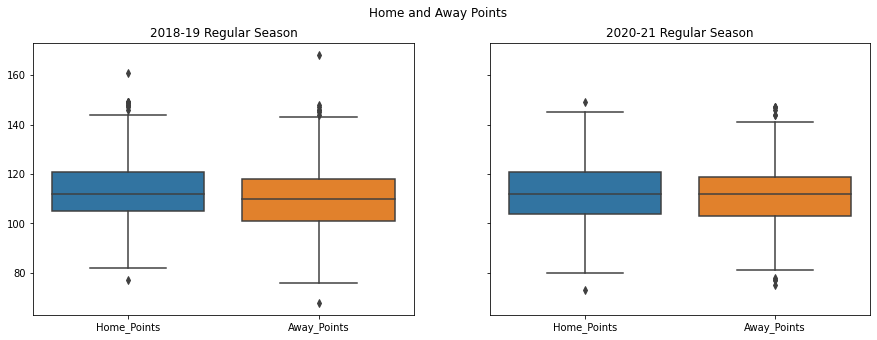

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5),sharey=True)
fig.suptitle('Home and Away Points')

sns.boxplot(ax = axes[0], data=df.loc[df['Season']=='2018-19'][['Home_Points','Away_Points']])
axes[0].set_title('2018-19 Regular Season')
sns.boxplot(ax = axes[1], data=df.loc[df['Season']=='2020-21'][['Home_Points','Away_Points']])
axes[1].set_title('2020-21 Regular Season')

In [57]:
print("------------2018-19------------")
print(df.loc[df['Season']=='2018-19'][['Home_Points','Away_Points']].describe())
print("------------2020-21------------")
print(df.loc[df['Season']=='2020-21'][['Home_Points','Away_Points']].describe())

------------2018-19------------
       Home_Points  Away_Points
count  1009.000000  1009.000000
mean    112.630327   109.982161
std      12.684164    12.438088
min      77.000000    68.000000
25%     105.000000   101.000000
50%     112.000000   110.000000
75%     121.000000   118.000000
max     161.000000   168.000000
------------2020-21------------
       Home_Points  Away_Points
count   655.000000   655.000000
mean    112.592366   111.450382
std      12.414611    12.246334
min      73.000000    75.000000
25%     104.000000   103.000000
50%     112.000000   112.000000
75%     121.000000   119.000000
max     149.000000   147.000000


Em ambas temporadas, o time da casa possui uma média de pontos superior em relação ao time visitante, no entanto como podemos observar, a diferença entre a média de pontos em 2018-19 era de quase 3 pontos e em 2020-21 caiu para quase 1 ponto. A temporada regular 2018-19 também possui outliers de pontuações bem altas que não estão presentes na temporada regular de 2020-21, mas isto não deve ser levado em conta uma vez que estas pontuações são referentes ao evento festivo do jogo das estrelas, que foi o único jogo fora da temporada regular que o Web Scrapping acabou coletando por ocorrer na metade da temporada. A temporada regular 2020-21 também tem presente este jogo das estrelas mas a pontuação não foi tão expressiva quanto na temporada 2018-19.

### Distribuição da diferença de pontos entre o time local e o time visitante

Na terceira análise, foi utilizado um histograma para cada temporada regular com intuito medir a frequência da diferença de pontuações entre o time da casa e o time visitante.

Text(0.5, 1.0, '2020-21 Regular Season')

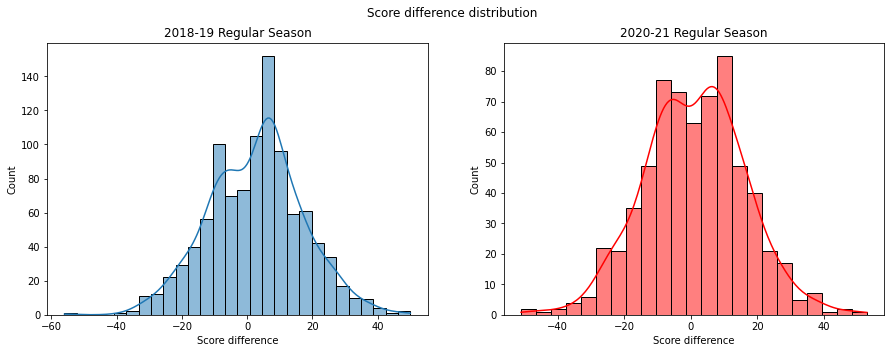

In [71]:
df['diff'] = df['Home_Points'] - df['Away_Points'] # coluna diferença de pontos
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Score difference distribution')

sns.histplot(ax = axes[0],data=df.loc[df['Season']=='2018-19'][['diff']], x="diff", kde=True).set(xlabel='Score difference')
axes[0].set_title('2018-19 Regular Season')
sns.histplot(ax = axes[1],data=df.loc[df['Season']=='2020-21'][['diff']], x="diff", kde=True,color='red').set(xlabel='Score difference')
axes[1].set_title('2020-21 Regular Season')

O primeiro ponto a entender desses gráficos é que como não existe empate no jogo de basquete, o valor 0 não tem ocorrências. Dito isso, podemos ver uma clara diferença nos gráficos, onde o primeiro mostra um pico de jogos em que a diferença de pontos do time da casa pro time visitante foi positiva, ou seja, o time da casa venceu. No segundo gráfico, este pico ainda existe, mas a diferença dele para o pico dos valores negativos, onde o time visitante ganhou, é bem menor. Isso mostra um indício forte de como o fato da presença de torcida gerou um efeito visível na distribuição da diferença de pontos entre o time da casa e o time visitante.

### Função de distribuição acumulada para diferença de pontos entre time local e time visitante

Na última análise, faremos o gráfico da função de distribuição acumulada, para entender se a probabilidade de o time da casa vencer o time visitante foi alterada.

[Text(0.5, 0, 'Score difference'), Text(0, 0.5, 'Probability')]

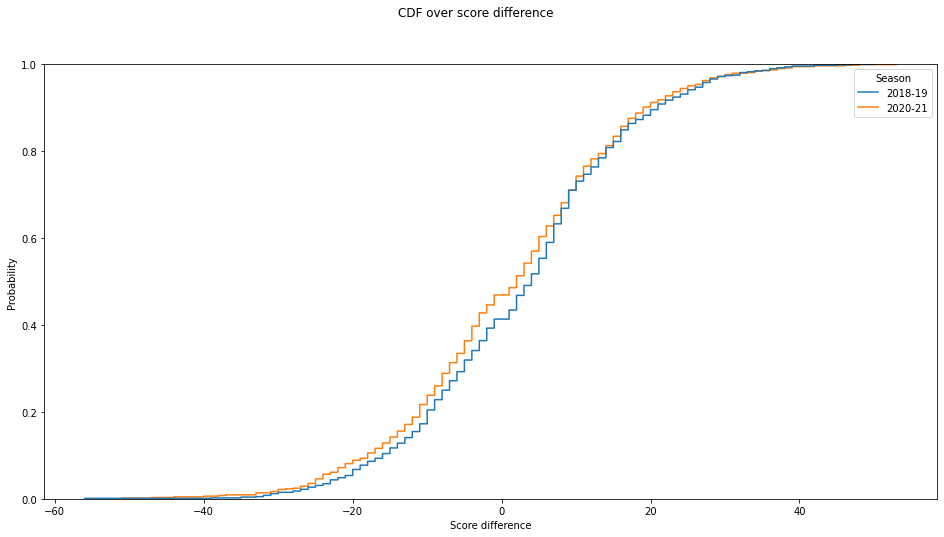

In [69]:
f=plt.figure(figsize=(16,8))
f.suptitle('CDF over score difference')
sns.ecdfplot(data=df[['diff','Season']], x="diff", hue="Season").set(xlabel='Score difference', ylabel='Probability')

O gráfico mostra que a probabilidade da diferença de pontos do time da casa com o time visitante ser positiva, ou seja, do time da casa vencer de fato diminuiu da temporada 2018-19 para a temporada 2020-21. A curva da função de distribuição acumulada possui um evidente deslocamento pra esquerda.

___

# Conclusão

Ao final, podemos afirmar que a vantagem relativa a presença de torcida no estádio pode ter influenciado a uma queda de desempenho dos times jogando em casa em relação aos times visitantes. Os times jogando em casa ainda possuem melhor desempenho, mas houve uma evidente queda no aproveitamento entre a temporada regular 2018-20 com presença de torcida e a temporada regular 2020-21 sem a presença de torcida.

É importante pontuar também que a análise realizada possui limitações. Não se foi considerada que a menor duração das férias dos jogadores possa ter tido um impacto no desempenho dos atletas. Também não se foi utilizado uma média histórica de resultados anteriores a 2018 para saber se a diferença entre as temporadas regulares 2018-19 e 2020-21 possa ser uma tendência que vem ocorrendo ao longo dos anos, e não um evento pontual que ocorreu por conta exclusivamente da falta de torcida em 2020 e 2021.

Por fim, para trabalhos futuros recomenda-se a análise histórica do fator torcida, assim como a utilização da métrica de número de torcedores presente nos ginásios para realização de testes estatísticos que possam provar a influencia desta variável no resultado dos jogos.